In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/../utils.py'>

In [2]:
w = 1/2
sigma = 1
weights = np.array([w, 1-w])

In [3]:
m = 6
d = 1
LSI = 1 + (np.exp(m**2)+1)/2
LSI

2155615773557599.0

In [4]:
def gm1d_density(xx, m1, m2, sigma, w):
    return w*norm.pdf(xx, loc = m1, scale = sigma) + (1-w)*norm.pdf(xx, loc = m2, scale = sigma)

In [5]:
# ms = np.array([np.zeros(d), m*np.ones(d)])
ms = np.array([5*np.ones(d), 6*np.ones(d)])
# Sigmas = np.array([np.eye(d), np.eye(d)])
Sigmas = np.array([0.1*np.eye(d), 0.1*np.eye(d)])

Sigmas_inv = np.array([linalg.inv(Sigmas[0,:,:]), linalg.inv(Sigmas[1,:,:])])
logdets = np.log([linalg.det(Sigmas[0,:,:]), linalg.det(Sigmas[1,:,:])])

In [6]:
xx = np.linspace(-3, 10, 100)

yy = gm1d_density(xx, 0, m, 1, w)

In [7]:
true_mean = np.mean(ms, axis = 0)
true_cov = np.zeros((d, d))
for i in range(2):
    true_cov += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_cov = true_cov/2

## Algorithms

In [8]:
N = 200
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
gamma = 0.05

In [9]:
component = np.random.randint(2, size = N)
true_sample = np.zeros((d, N))
for n in range(N):
      true_sample[:, n] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)[0]

In [10]:
Niter = 1000

In [11]:
Nalgo = 6
Nrep = 50

ula_chain = np.zeros((Nrep, Niter, d, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))

In [12]:
w1_ula = np.zeros((Nrep, Niter, d))
w1_fr = np.zeros((Nrep, Niter, d))
w1_wfr = np.zeros((Nrep, Niter, d))

In [13]:
for i in range(Nrep):
    ### ULA
    _, w1_ula[i,:], _ = algo.ParallelULA(gamma, Niter, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample, true_cov)
    ### SMC-FR
    _, _, w1_fr[i,:], _ = algo.SMC_UnitFR(gamma, Niter, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample, true_cov, 1)
    ### SMC-WFR
    _, _, w1_wfr[i,:], _ = algo.SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample, true_cov, 1)

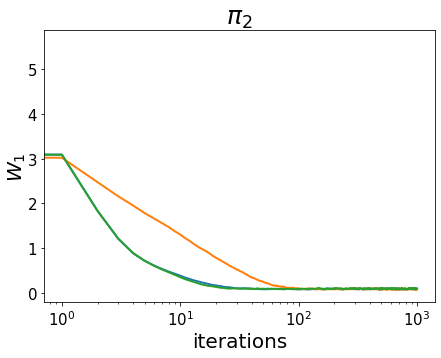

In [30]:
plt.figure(figsize = (7,5))
plt.semilogx(np.mean(w1_ula, axis = 0), label = 'ULA', lw = 2)
plt.plot(np.mean(w1_fr, axis = 0), label = 'SMC-tempering', lw = 2)
plt.plot(np.mean(w1_wfr, axis = 0), label = 'SMC-WFR', lw = 2)
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.title('$\pi_2$', fontsize = 25)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('w1_mixture2.pdf', bbox_inches="tight")

In [15]:
# def export_legend(legend, filename="legend_mixture.pdf", expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
# plt.show()